In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input











ModuleNotFoundError: No module named 'tensorflow'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
sns.set_style('darkgrid')

In [ ]:
# Definisikan path dataset
base_dir = '/content/drive/MyDrive/Proyek Data Mining/Dataset/image classification Sampah'
train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir, 'Test')


In [ ]:
# Pastikan direktori ada
for directory in [train_dir, valid_dir, test_dir]:
    if not os.path.exists(directory):
        raise FileNotFoundError(f'Direktori "{directory}" tidak ditemukan.')

In [ ]:
# Fungsi untuk membuat DataFrame dari direktori
def create_dataframe(directory):
    filepaths = []
    labels = []
    classlist = os.listdir(directory)
    for klass in classlist:
        classpath = os.path.join(directory, klass)
        if os.path.isdir(classpath):
            for f in os.listdir(classpath):
                filepaths.append(os.path.join(classpath, f))
                labels.append(klass)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [ ]:
# Buat DataFrame untuk masing-masing dataset
train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)

In [ ]:
# Tampilkan beberapa contoh data dan distribusi label
print(train_df.head())
print(train_df['labels'].value_counts())
print(valid_df.head())
print(valid_df['labels'].value_counts())
print(test_df.head())
print(test_df['labels'].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
1  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
2  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
3  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
4  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
labels
kertas     80
organik    80
plastik    80
Name: count, dtype: int64
                                           filepaths  labels
0  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
1  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
2  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
3  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
4  /content/drive/MyDrive/Proyek Data Mining/Data...  kertas
labels
kertas     10
organik    10
plastik    10
Name: count, dtype: int64
                                           filepaths  labels
0  /content/drive/MyDrive/Proyek Data Mining/Data...  ker

#Preprocessing


In [ ]:
# Definisikan ImageDataGenerator dan aliran data
# Parameter gambar
# Parameter gambar
height, width, channels = 224, 224, 3
batch_size = 64
img_size = (height, width)

# Image data generators dengan augmentasi data
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
).flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size
)

valid_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False
)


Found 240 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.
Found 30 validated image filenames belonging to 3 classes.


In [ ]:
# Tampilkan indeks kelas
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

['kertas', 'organik', 'plastik']


In [ ]:
# Tampilkan gambar sampel
def show_image_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize=(20, 20))
    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(classes[np.argmax(labels[i])], color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Tambahkan regulasi ke model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(height, width, channels))
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 128)               36

In [ ]:
# Definisikan callbacks untuk early stopping dan model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('yak_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Latih model
history = model.fit(train_gen, validation_data=valid_gen, epochs=25, callbacks=[checkpoint, early_stopping], verbose=1)

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 3.7263 - accuracy: 0.4833 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 94s 24s/step - loss: 3.7263 - accuracy: 0.4833 - val_loss: 2.6800 - val_accuracy: 0.9333
Epoch 2/25
4/4 [==============================] - 70s 19s/step - loss: 3.2654 - accuracy: 0.6292 - val_loss: 2.6341 - val_accuracy: 0.8000
Epoch 3/25
4/4 [==============================] - 70s 16s/step - loss: 2.8498 - accuracy: 0.7708 - val_loss: 2.5483 - val_accuracy: 0.8667
Epoch 4/25
4/4 [==============================] - 65s 17s/step - loss: 2.7415 - accuracy: 0.8000 - val_loss: 2.4315 - val_accuracy: 0.9333
Epoch 5/25
4/4 [==============================] - 66s 16s/step - loss: 2.4467 - accuracy: 0.9000 - val_loss: 2.3492 - val_accuracy: 0.9333
Epoch 6/25
4/4 [==============================] - 67s 16s/step - loss: 2.3283 - accuracy: 0.9042 - val_loss: 2.3722 - val_accuracy: 0.9000
Epoch 7/25
4/4 [==============================] - 64s 17s/step - loss: 2.2514 - accuracy: 0.9375 - val_loss: 2.5326 - val_accuracy: 0.8667
Epoch 8/25
4/4 [======================

In [ ]:
# Muat model terbaik
best_model = tf.keras.models.load_model('yak_model.h5')

In [ ]:
# Evaluasi model pada data test
test_loss, test_accuracy = best_model.evaluate(test_gen, verbose=1)
print(f'Akurasi pada data test: {test_accuracy * 100:.2f}%')

1/1 [==============================] - 7s 7s/step - loss: 1.5394 - accuracy: 0.9000
Akurasi pada data test: 90.00%


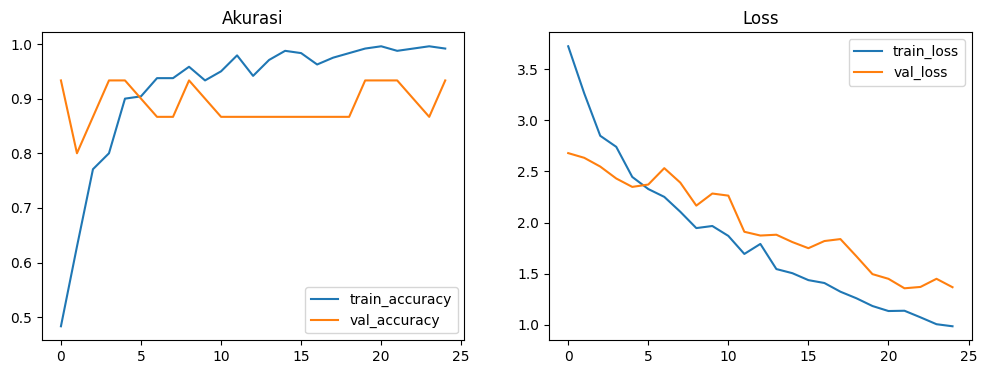

In [ ]:
# Plot riwayat pelatihan
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Akurasi')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:

# Prediksi pada data test
y_pred = np.argmax(best_model.predict(test_gen), axis=-1)
y_true = test_gen.classes

1/1 [==============================] - 10s 10s/step


Classification Report
              precision  recall  f1-score  support
kertas         0.909091     1.0  0.952381     10.0
organik        0.833333     1.0  0.909091     10.0
plastik        1.000000     0.7  0.823529     10.0
accuracy       0.900000     0.9  0.900000      0.9
macro avg      0.914141     0.9  0.895000     30.0
weighted avg   0.914141     0.9  0.895000     30.0
Confusion Matrix


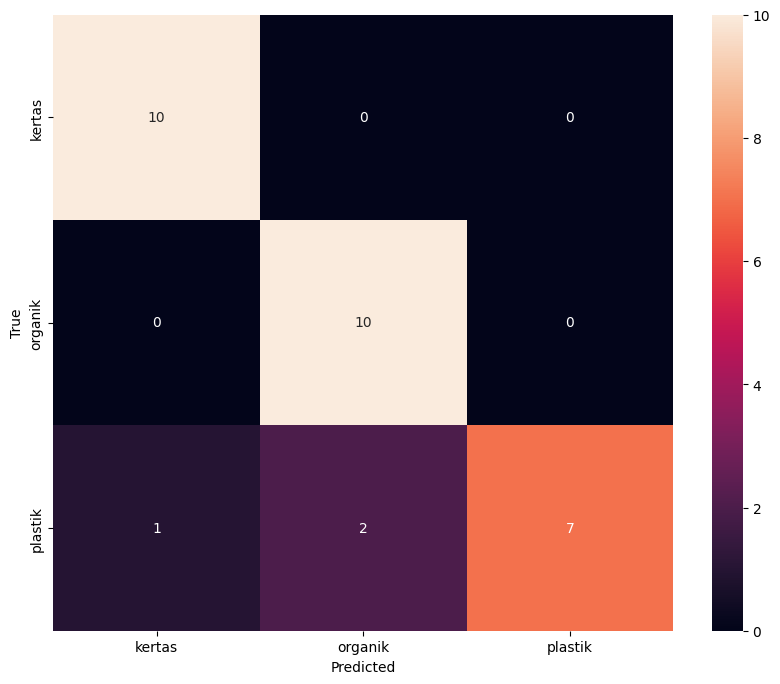

In [ ]:
# Classification report dan confusion matrix
print('Classification Report')
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Tampilkan beberapa prediksi
def show_prediction_samples(generator, model, classes, num_samples=25):
    images, labels = next(generator)
    predictions = model.predict(images)
    plt.figure(figsize=(30, 20))
    for i in range(min(num_samples, len(labels))):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {classes[np.argmax(labels[i])]}, Pred: {classes[np.argmax(predictions[i])]}", color='blue', fontsize=10)
        plt.axis('off')
    plt.show()

show_prediction_samples(test_gen, best_model, classes)

Output hidden; open in https://colab.research.google.com to view.